In [18]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [16]:
# 2b
data = np.genfromtxt('clase_8_dataset.csv', delimiter=',')
print(data.shape)

(500, 2)


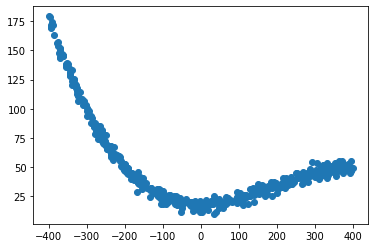

In [22]:
# 2c
plt.scatter(data[:, 0], data[:, 1])

In [24]:
# 2d

def split_dataset(dataset, train=70, validate=20):
    """
    This function splits a dataset into training, validation and testing
    
    :param dataset: the dataset to be split
    :param train: the percentage of the samples to be used for training, expressed as percentage
    :param validate: the percentage of the samples to be used for validation, expressed as percentage.
        The remaining of training and validation is used for testing
    :return:
        - Training set
        - Validation set
        - Testing set (might be empty)
    """
    
    # Validate input and calculate testing percentage
    if train >= 100:
        return None
    if train + validate > 100:
        validate = 100 - train
    test = 100 - train - validate
    
    # Get the indexes for splitting the dataset
    n_elements = dataset.shape[0]
    train_lim = int(n_elements * train / 100)
    validate_lim = int(n_elements * (train + validate) / 100)
    
    # Permutate and split the dataset and return it
    dataset = np.random.permutation(dataset)
    return(dataset[:train_lim], dataset[train_lim:validate_lim], dataset[validate_lim:])

train, test, _ = split_dataset(data, train=80, validate=20)
print(train.shape, test.shape)

(400, 2) (100, 2)


861.7029363659258


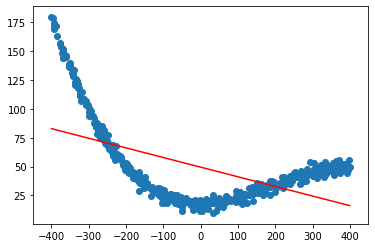

In [39]:
# 3a

def poly_regression_closed(X, y, orden):
    # Calculo los arrays con las potencias de X que son necesarias para la regresión polinómica
    X_pow = np.empty((X.shape[0], orden + 1))
    X_pow[:, 0] = 1
    X_pow[:, 1] = X
    for i in range(2, orden + 1):
        X_pow[:, i] = X ** i

    # Calculo los coeficientes del polinomio y los devuelvo
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(X_pow.T, X_pow)), X_pow.T), y)

def predict(coeffs, value):
    # Predice el valor del modelo para los coeficientes dados y la abscisa dada
    return sum([c * value ** j for j, c in enumerate(coeffs)])

def plot_line(coeffs, min_range=-400, max_range=400, step=1):
    # Plotea una linea con las predicciones para el rango establecido
    linea = []
    for i in range(min_range, max_range, step):
        linea.append(predict(coeffs, i))
    plt.plot(range(min_range, max_range, step), linea, 'r')
    plt.scatter(data[:, 0], data[:, 1])

def mse(truth, prediction):
        return np.mean((truth - prediction) ** 2)
    
def k_folds(
        X_train,
        y_train,
        k=5,
        fit_method=poly_regression_closed,
        param_fit=1,
        predict_method=predict,
        error_method=mse
):
    chunk_size = int(len(X_train) / k)
    mse_list = []
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        coeffs = fit_method(new_X_train, new_y_train, param_fit)
        prediction = predict_method(coeffs, new_X_valid)
        mse_list.append(error_method(new_y_valid, prediction))

    mean_MSE = np.mean(mse_list)
    return mean_MSE
    
# Separo la entrada de la salida
X = train[:, 0]
y = train[:, 1]

# Mostrar el MSE promedio
print(k_folds(X, y))

# Mostrar la gráfica de la predicción
coeffs = poly_regression_closed(X, y, 1)
plot_line(coeffs)

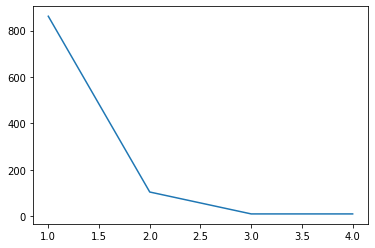

In [43]:
# 3b
cost = [861.7]  # Lo inicio con el peso del inciso anterior
for i in range(2, 5):
    cost.append(k_folds(X, y, param_fit=i))
    
plt.plot(range(1, 5), cost)

3c

A juzgar por el gráfico anterior parecería tener sentido usar el polinomio de orden 3, dado que el de orden 4 no presenta mejoras apreciables respecto a la reducción del costo y tendría mayores chances de presentar overfitting. Si el de orden 3 tuviera overfitting, el de orden 2 parece una buena alternativa también.

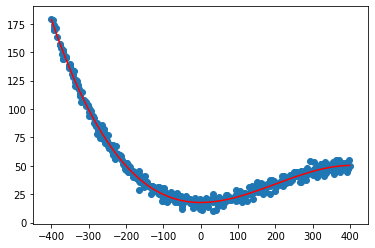

In [48]:
# 3d

# Mostramos la aproximación polinómica de orden 3 junto con la nube de puntos
coeffs = poly_regression_closed(X, y, 3)
plot_line(coeffs)


La gráfica anterior parece confirmar que la elección del polinomio de orden 3 es acertada.

In [68]:
def predict_array(coeffs, values):
    # Predice el valor del modelo para los coeficientes dados y las abscisas dadas
    return np.sum([c * values ** j for j, c in enumerate(coeffs)], axis=1)

def mini_batch_gradient_descent(X_train, y_train, lr=0.01, amt_epochs=1, b=16):
    
    """
    shapes:
        X_train = nx1
        y_train = nx1
        W = mx1
    """
    
    X_train = X_train.reshape((len(X_train), 1))
    y_train = y_train.reshape((len(y_train), 1))
    
    n = X_train.shape[0]
    m = 3

    # initialize random weights
    W = np.random.randn(m).reshape(m, 1)

    # iterate over the n_epochs
    for i in range(amt_epochs):
        
        # Shuffle all the samples 
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # Calculate the batch size in samples as a function of the number of batches
        batch_size = int(len(X_train) / b)
 
        # Iterate over the batches
        for i in range(0, len(X_train), batch_size):
            
            end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[i: end] # batch_size*1
            batch_y = y_train[i: end] # batch_size*1

            # Calculate the prediction for the whole batch
            W = poly_regression_closed(batch_X, batch_y, 3)
            prediction = predict_array(W, batch_X)
            
            # Calculate the error for the whole batch
            error = mse(batch_y, prediction)  # batch_sizex1

            # Calculate the gradient for the batch
            
            # error[batch_sizex1]*batch_X[batch_size*m]--> broadcasting --> batch_size*m
            print(batch_X.shape)
            grad_sum = np.sum(error * batch_X, axis=0) # 1xm
            print(grad_sum.shape)
            grad_mul = -2/batch_size * grad_sum  # 1xm
            gradient = np.transpose(grad_mul)  # mx1
            
            # Update the weights
            W = W - (lr * gradient)

        # Print values per epoch
        print('Train error: ', error)
        print('Validation error: ', mse(test[:, 1], predict_array(W, test[:, 0])))
            
    return W

print(mini_batch_gradient_descent(X, y))

ValueError: could not broadcast input array from shape (25,1) into shape (25)